# Rapport data challenge

## Résumé

Pour obtenir un F1-score optimal, les paramètres suivants ont été utilisés :
* Classifieur **SVM avec kernel Tanimoto**, paramètre de régularisation **C=6**
* 7 feature extractors
  1) Parameter-Free Threshold Adjacency Statistics
  2) Statistiques des canaux de couleur (moyenne, écart-type, asymétrie, kurtosis)
  3) Hu Moments
  4) Features de texture Haralick (distance=2, moyenne Point-to-Point et 14 features calculées)
  5) Histogramme de couleurs avec 11 bins
  6) Local Binary Patterning, avec un rayon de 9 pixels et 72 points
  7) Descripteurs SIFT, clusterisés avec 300 centroides

## Import des librairies et des données

In [142]:
import matplotlib.pyplot as plt
import numpy as np
import os
from tqdm.notebook import tqdm
from PIL import Image
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.decomposition import PCA, KernelPCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score, train_test_split, LeaveOneOut
from scipy.stats import skew, kurtosis
from datetime import datetime
import pandas as pd
import cv2
import mahotas
from mahotas.features import surf
from skimage.feature import local_binary_pattern
import umap.umap_ as umap
import pykernels
from tabulate import tabulate
import copy
import itertools

In [2]:
class_mapping = {"F":1, "DC":2, "PC":3, "PT":4, "MC":5, "LC":6, "A":7, "TA":8}
# Liste contenant le nom des fichiers de Train
files_train = [f"data-challenge/Train/{f}" for f in os.listdir(path="data-challenge/Train/")]
# Liste contenant le nom des fichiers de Test
files_test = [f"data-challenge/Test/SOB_{i}.png" for i in range(1, 208)]
y_train = np.array([int(class_mapping[f.split("_")[2].split("-")[0]]) for f in files_train])

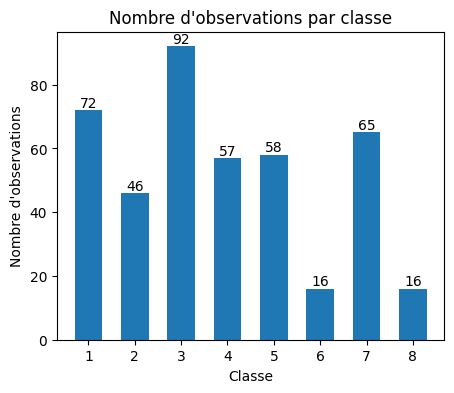

In [3]:
label, count = np.unique(y_train, return_counts=True)
fig, ax = plt.subplots(figsize=(5, 4))
bars = ax.bar(label, count, width=0.6)
ax.bar_label(bars)
ax.set_xlabel("Classe")
ax.set_ylabel("Nombre d'observations")
ax.set_title("Nombre d'observations par classe")
plt.show()

On observe que le jeu d'entraînement est déséquilibré, les classes 6 et 8 sont sous-représentées. Le nombre minimal d'observations dans une classe est de 16.

## Méthodologie

&nbsp;&nbsp;D'après l'état de l'art, les meilleurs résultats pour la classification d'images histopathologiques de tumeurs du sein sont tous obtenus avec des réseaux de neurones convolutionnels. Cependant, notre jeu de données ne contient que 422 images d'entraînement, ce qui à première vue semble insuffisant pour entraîner un réseau de neurones performant. J'ai donc préféré adopter une approche basée sur du feature engineering avec un classifieur basé sur du machine learning classique. <br>


&nbsp;&nbsp;Je me suis inspiré des méthodes décrites dans l'introduction de l'article suivant (https://arxiv.org/pdf/1811.04241.pdf) pour sélectionner les features les plus intéressantes à tester en priorité : <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;*Before the deep learning revolution, machine learning approaches including the
Support Vector Machine (SVM), Principle Component Analysis (PCA), and Random Forest (RF) were used to study
data whose features were extracted with **Scale Invariant Feature Extraction (SIFT)**, **Local Binary Patterning (LBP)**, **Local Phase Quantization (LPQ)**, the **Gray-Level Co-occurrence Matrix (GLCM)**, **Threshold Adjacency Statistics (TAS)**, and **Parameter Free TAS (PFTAS)**. In 2016, one of the very popular databases for BC classification problem was released, and one research group reported approximately 85.1% accuracy utilizing SVM and PFTAS features for patient-level analysis, which was the highest recognition accuracy at the time.*

Ma démarche de création de classifieur optimal peut se résumer en 3 étapes principales :
1) <u>Sélection d'un classifieur </u>: Parmi les différentes méthodes d'extraction citées ci-dessus, certaines ne nécessitent peu ou pas de configuration pour générer des features (PFTAS, Haralick, Hu Moments). J'ai donc commencé par tester différents classifieurs sur les features extraites avec ces méthodes pour sélectionner un seul classifieur plus performant. <br>
2) <u> Optimisation de features pour le classifieur retenu</u>: D'autres méthodes d'extraction se basent sur des features locales, ou ont besoin de plus de paramètres pour être configurées (Histogramme de couleurs, LBP, SIFT). J'ai donc configuré ces méthodes d'extraction pour fournir unitairement le score le plus élevé avec le classifieur retenu à l'étape 1.<br>
3) <u>Optimisation de la combinaison des features </u>: Enfin, après combinaison des features, j'ai réoptimisé la configuration de la génération des features pour obtenir le meilleur score possible avec l'ensemble des features.

&nbsp;&nbsp;Pour ce qui est de la méthodologie de test, le jeu d'entraînement ne comporte que 422 images. **Il se prête donc assez mal à un découpage `train_test_split` classique**. Le jeu d'entraînement étant petit, il est improbable qu'il contienne toute la variance de chaque classe. Diminuer ce jeu d'entraînement pour réaliser un jeu unique de cross validation semble donc une mauvaise idée, car il risque de créer de l'overfitting sur le jeu de cross validation ainsi créé, et de l'underfitting global sur la distribution des images. <br>
&nbsp;&nbsp;**J'ai donc préféré utiliser la méthode `cross_val_score` de scikit-learn** pour tester les hyperparamètres de mes différents modèles, et comparer les modèles entre eux. L'évaluation du data-challenge étant basée sur le F1-Score `"weigthed"`, je n'ai utilisé `cross_val_score` qu'avec le paramètre `scoring="f1_weighted"`, et conservé la moyenne des scores obtenus sur chaque fold comme métrique. Le jeu d'entraînement étant petit, un nombre de folds important permet de maximiser l'information apprise par chaque modèle, et de réduire la variance entre les scores obtenus sur chaque fold. J'ai donc maximisé le paramètre `cv` lors de l'entraînement. Dans notre cas, le maximum attribuable à `cv` est 16, car c'est le nombre d'observations que contient la classe la moins représentée (classes 6 et 8). <br>
&nbsp;&nbsp;Dans la dernière étape, j'ai **utilisé la méthode de cross-validation `Leave-One-Out`** fournie par scikit-learn. Cette méthode permet d'avoir une évaluation plus robuste des performances du modèle testé, et donc d'avoir une évaluation plus précise du modèle avant utilisation sur le jeu de test. Cependant, elle est également plus calculatoire (421 fits réalisés pour chaque test), et l'utiliser dès le début aurait été très long coûteux à une étape ne nécessitant pas encore d'optimisation.

## Sélection d'un classifieur

Les différents classifieurs testés ont été les suivants:
* SVM
* Random Forest
* Gradient Boosting
* K-Nearest Neighbors
* LDA

RandomForest et GradientBoosting ont un grand nombre d'hyperparamètres, qui nécessitent d'être combinés pour aboutir à une augmentation importante du score. Ces modèles ont donc été testés avec des paramètres de bases, et leurs hyperparamètres optimisés uniquement si les scores qu'ils fournissent semblent le justifier. <br>
Différents tests ont également été réalisés avec PCA, afin de réduire la dimension des features avant classification. Les résultats n'étaient pas concluants, et n'ont donc pas été inclus dans ce rapport pour ne pas l'alourdir (les méthodes avec kernel fonctionnent très bien avec un grand nombre de features).

### Parameter-Free Threshold Adjacency Statistics (PFTAS)

Il est possible d'extraire les features PFTAS sur les images en noir et blanc, ce qui génère 54 features au lieu de 162. Les différents classifieurs ont été testés sur ces 54 features, mais obtenaient de manière unanime des scores moins bon qu'avec les 162 features extraites sur les images couleurs. Pour ne pas alourdir davantage ce rapport, ces résultats n'ont pas été intégrés à ce rapport. Par la suite, lorsqu'un extracteur de feature fonctionne sur des images couleur, il a toujours été utilisé sur les images couleur pour maximiser les informations disponibles. <br>
PFTAS est une feature d'image globale, qui ne nécessite pas de configuration particulière lors de l'utilisation de l'API Mahotas.

In [4]:
pftas = np.array([mahotas.features.pftas(np.array(Image.open(f))) for f in files_train])
pftas_test = np.array([mahotas.features.pftas(np.array(Image.open(f))) for f in files_test])
pftas.shape, pftas_test.shape

((422, 162), (207, 162))

In [5]:
scaler = StandardScaler()
pftas_scaled = scaler.fit_transform(pftas)

In [6]:
reg = range(1, 101)
score = []
for c in tqdm(reg):
    svm = SVC(C=c)
    score.append(np.mean(cross_val_score(svm, pftas_scaled, y_train, cv=16, scoring="f1_weighted")))
print(f"Best score for SVM is {np.max(score)} for C = {np.argmax(score) + 1}")
score_svm = np.max(score)

  0%|          | 0/100 [00:00<?, ?it/s]

Best score for SVM is 0.8209024919762099 for C = 17


In [7]:
rfc = RandomForestClassifier()
score_rfc = np.mean(cross_val_score(rfc, pftas, y_train, cv=16, scoring="f1_weighted"))
print(f"Score for Random Forest is {score_rfc}.")

Score for Random Forest is 0.7732068481534293.


In [8]:
gboost = GradientBoostingClassifier()
score_gboost = np.mean(cross_val_score(gboost, pftas, y_train, cv=16, scoring="f1_weighted"))
print(f"Score for Gradient Boosting is {score_gboost}.")

Score for Gradient Boosting is 0.7514329252577117.


In [9]:
neigh = range(1, 101)
score = []
for k in tqdm(neigh):
    knn = KNeighborsClassifier(n_neighbors=k)
    score.append(np.mean(cross_val_score(knn, pftas_scaled, y_train, cv=16, scoring="f1_weighted")))
print(f"Best score for KNN is {np.max(score)} for k = {np.argmax(score) + 1}")
score_knn = np.max(score)

  0%|          | 0/100 [00:00<?, ?it/s]

Best score for KNN is 0.7631828834152552 for k = 1


In [10]:
lda = LinearDiscriminantAnalysis()
score_lda = np.mean(cross_val_score(lda, pftas, y_train, cv=16, scoring="f1_weighted"))
print(f"Score for LDA classifier is {score_lda}.")

Score for LDA classifier is 0.7229427391419913.


In [11]:
lr = LogisticRegression(max_iter=500)
score_lr = np.mean(cross_val_score(lr, pftas_scaled, y_train, cv=16, scoring="f1_weighted"))
print(f"Score for Logistic Regression classifier is {score_lr}.")

Score for LDA classifier is 0.7664051182080028.


In [12]:
print("Récapitulatif des F1-scores obtenus par Cross Validation")
f1_scores = []
f1_scores.append(["PFTAS", score_svm, score_rfc, score_gboost, score_knn, score_lda, score_lr])
tabulate(f1_scores, headers=["Feature", "SVM", "RandomForest", "GradientBoosting", "KNN", "LDA", "LogisticRegression"],
         tablefmt="html", floatfmt=".3f", numalign="center")

Récapitulatif des F1-scores obtenus par Cross Validation


Feature,SVM,RandomForest,GradientBoosting,KNN,LDA,LogisticRegression
PFTAS,0.821,0.773,0.751,0.763,0.723,0.766


### Color channel statistics

Une feature facile à calculer est la moyenne et l'écart-type de chaque canal de couleur. La librairie `scipy` permet également de calculer les moments d'ordre 3 et 4, je les ai donc ajouté aux moyennes et écart-types calculés. <br>
Pour chacun des 3 canaux sont donc extraits 4 valeurs (moyenne, écart-type, asymétrie et kurtosis), ce qui revient à créer 12 features par image.

In [13]:
chan_stats = np.array([np.concatenate([np.mean(Image.open(f), axis=(0,1)),
                                       np.std(Image.open(f), axis=(0,1)),
                                       skew(Image.open(f), axis=(0,1)),
                                       kurtosis(Image.open(f), axis=(0,1))]) for f in files_train])
chan_stats_test = np.array([np.concatenate([np.mean(Image.open(f), axis=(0,1)),
                                       np.std(Image.open(f), axis=(0,1)),
                                       skew(Image.open(f), axis=(0,1)),
                                       kurtosis(Image.open(f), axis=(0,1))]) for f in files_test])
chan_stats.shape, chan_stats_test.shape

((422, 12), (207, 12))

In [14]:
scaler = StandardScaler()
chan_stats_scaled = scaler.fit_transform(chan_stats)

In [15]:
reg = range(1, 101)
score = []
for c in tqdm(reg):
    svm = SVC(C=c)
    score.append(np.mean(cross_val_score(svm, chan_stats_scaled, y_train, cv=16, scoring="f1_weighted")))
print(f"Best score for SVM is {np.max(score)} for C = {np.argmax(score) + 1}")
score_svm = np.max(score)

  0%|          | 0/100 [00:00<?, ?it/s]

Best score for SVM is 0.822807826867656 for C = 29


In [16]:
rfc = RandomForestClassifier()
score_rfc = np.mean(cross_val_score(rfc, chan_stats, y_train, cv=16, scoring="f1_weighted"))
print(f"Score for Random Forest is {score_rfc}.")

Score for Random Forest is 0.7136460356278732.


In [17]:
gboost = GradientBoostingClassifier()
score_gboost = np.mean(cross_val_score(gboost, chan_stats, y_train, cv=16, scoring="f1_weighted"))
print(f"Score for Gradient Boosting is {score_gboost}.")

Score for Gradient Boosting is 0.6692996170693821.


In [18]:
neigh = range(1, 101)
score = []
for k in tqdm(neigh):
    knn = KNeighborsClassifier(n_neighbors=k)
    score.append(np.mean(cross_val_score(knn, chan_stats_scaled, y_train, cv=16, scoring="f1_weighted")))
print(f"Best score for KNN is {np.max(score)} for k = {np.argmax(score) + 1}")
score_knn = np.max(score)

  0%|          | 0/100 [00:00<?, ?it/s]

Best score for KNN is 0.7619063618796524 for k = 1


In [19]:
lda = LinearDiscriminantAnalysis()
score_lda = np.mean(cross_val_score(lda, chan_stats, y_train, cv=16, scoring="f1_weighted"))
print(f"Score for LDA classifier is {score_lda}.")

Score for LDA classifier is 0.51524350777823.


In [20]:
lr = LogisticRegression(max_iter=500)
score_lr = np.mean(cross_val_score(lr, chan_stats_scaled, y_train, cv=16, scoring="f1_weighted"))
print(f"Score for Logistic Regression classifier is {score_lr}.")

Score for LDA classifier is 0.5571158408898793.


In [21]:
print("Récapitulatif des F1-scores obtenus par Cross Validation")
f1_scores.append(["Color channel statistics", score_svm, score_rfc, score_gboost, score_knn, score_lda, score_lr])
tabulate(f1_scores, headers=["Feature", "SVM", "RandomForest", "GradientBoosting", "KNN", "LDA", "LogisticRegression"],
         tablefmt="html", floatfmt=".3f", numalign="center")

Récapitulatif des F1-scores obtenus par Cross Validation


Feature,SVM,RandomForest,GradientBoosting,KNN,LDA,LogisticRegression
PFTAS,0.821,0.773,0.751,0.763,0.723,0.766
Color channel statistics,0.823,0.714,0.669,0.762,0.515,0.557


### Hu Moments

Les Moments de Hu ne peuvent se calculer que sur des images en niveau de gris (d'où la conversion 'L' via PIL)

In [22]:
moments = [cv2.moments(np.array(Image.open(f).convert('L'))) for f in files_train]
moments_test = [cv2.moments(np.array(Image.open(f).convert('L'))) for f in files_test]
hu = np.array([cv2.HuMoments(m).T for m in moments])[:,0,:]
hu_test = np.array([cv2.HuMoments(m).T for m in moments_test])[:,0,:]
hu.shape, hu_test.shape

((422, 7), (207, 7))

In [23]:
scaler = StandardScaler()
hu_scaled = scaler.fit_transform(hu)

In [24]:
reg = range(1, 101)
score = []
for c in tqdm(reg):
    svm = SVC(C=c)
    score.append(np.mean(cross_val_score(svm, hu_scaled, y_train, cv=16, scoring="f1_weighted")))
print(f"Best score for SVM is {np.max(score)} for C = {np.argmax(score) + 1}")
score_svm = np.max(score)

  0%|          | 0/100 [00:00<?, ?it/s]

Best score for SVM is 0.27556334606948923 for C = 45


In [25]:
rfc = RandomForestClassifier()
score_rfc = np.mean(cross_val_score(rfc, hu, y_train, cv=16, scoring="f1_weighted"))
print(f"Score for Random Forest is {score_rfc}.")

Score for Random Forest is 0.14585625181244838.


In [26]:
gboost = GradientBoostingClassifier()
score_gboost = np.mean(cross_val_score(gboost, hu, y_train, cv=16, scoring="f1_weighted"))
print(f"Score for Gradient Boosting is {score_gboost}.")

Score for Gradient Boosting is 0.14508764027994797.


In [27]:
neigh = range(1, 101)
score = []
for k in tqdm(neigh):
    knn = KNeighborsClassifier(n_neighbors=k)
    score.append(np.mean(cross_val_score(knn, hu_scaled, y_train, cv=16, scoring="f1_weighted")))
print(f"Best score for KNN is {np.max(score)} for k = {np.argmax(score) + 1}")
score_knn = np.max(score)

  0%|          | 0/100 [00:00<?, ?it/s]

Best score for KNN is 0.26239244983514454 for k = 33


In [28]:
lda = LinearDiscriminantAnalysis()
score_lda = np.mean(cross_val_score(lda, hu, y_train, cv=16, scoring="f1_weighted"))
print(f"Score for LDA classifier is {score_lda}.")

Score for LDA classifier is 0.22647633404414946.


In [29]:
lr = LogisticRegression(max_iter=500)
score_lr = np.mean(cross_val_score(lr, hu_scaled, y_train, cv=16, scoring="f1_weighted"))
print(f"Score for Logistic Regression classifier is {score_lr}.")

Score for LDA classifier is 0.2473048105489527.


In [30]:
print("Récapitulatif des F1-scores obtenus par Cross Validation")
f1_scores.append(["Hu moments", score_svm, score_rfc, score_gboost, score_knn, score_lda, score_lr])
tabulate(f1_scores, headers=["Feature", "SVM", "RandomForest", "GradientBoosting", "KNN", "LDA", "LogisticRegression"],
         tablefmt="html", floatfmt=".3f", numalign="center")

Récapitulatif des F1-scores obtenus par Cross Validation


Feature,SVM,RandomForest,GradientBoosting,KNN,LDA,LogisticRegression
PFTAS,0.821,0.773,0.751,0.763,0.723,0.766
Color channel statistics,0.823,0.714,0.669,0.762,0.515,0.557
Hu moments,0.276,0.146,0.145,0.262,0.226,0.247


Les scores obtenus via Hu Moments semblent vraiment très faibles comparés aux 2 features précédentes. Cependant, après combinaison avec d'autres features, il apparaît que l'utilisation de ces 7 features participe à l'augmentation du score de classification. Elles ont donc été conservées.

### Haralick

Haralick permet d'extraire des informations de texture globales sur chaque image. De même que pour PFTAS, son utilisation sur des images en couleur génère des features en plus grande dimension, mais fournissant un score de classification plus élevé. <br>
3 paramètres principaux peuvent être configurés sur cette feature via l'API Mahotas :
* distance : vaut 1 ou 2. Les tests ci-dessous justifient la configuration de ce paramètre à 2
* return_mean : permet de retourner la moyenne selon toutes les directions (return_mean=True) ou la moyenne et ptp (point-to-point = difference entre max() and min()). De manière empirique, il apparaît que return_mean_ptp=True à un fort impact sur le score
* compute_14th_feature : permet de calculer une 14ème feature Haralick

In [31]:
h1 = np.array([mahotas.features.haralick(np.array(Image.open(f)), return_mean=True,
                                         compute_14th_feature=False, distance=1) for f in files_train])
# Point-to-point (max-min) mean instead of standard mean
h2 = np.array([mahotas.features.haralick(np.array(Image.open(f)), return_mean_ptp=True,
                                         compute_14th_feature=False, distance=1) for f in files_train])
# With 14th feature and standard mean
h3 = np.array([mahotas.features.haralick(np.array(Image.open(f)), return_mean=True,
                                         compute_14th_feature=True, distance=1) for f in files_train])
# With 14th feature and point-to-point mean
h4 = np.array([mahotas.features.haralick(np.array(Image.open(f)), return_mean_ptp=True,
                                         compute_14th_feature=True, distance=1) for f in files_train])

In [32]:
scaler = StandardScaler()
h1_scaled = scaler.fit_transform(h1)
h2_scaled = scaler.fit_transform(h2)
h3_scaled = scaler.fit_transform(h3)
h4_scaled = scaler.fit_transform(h4)

In [33]:
reg = range(1, 101)
score1, score2, score3, score4 = [], [], [], []
for c in tqdm(reg):
    svm = SVC(C=c)
    score1.append(np.mean(cross_val_score(svm, h1_scaled, y_train, cv=16, scoring="f1_weighted")))
    score2.append(np.mean(cross_val_score(svm, h2_scaled, y_train, cv=16, scoring="f1_weighted")))
    score3.append(np.mean(cross_val_score(svm, h3_scaled, y_train, cv=16, scoring="f1_weighted")))
    score4.append(np.mean(cross_val_score(svm, h4_scaled, y_train, cv=16, scoring="f1_weighted")))
print(f"Best score1 for SVM is {np.max(score1)} for C = {np.argmax(score1) + 1}")
print(f"Best score2 for SVM is {np.max(score2)} for C = {np.argmax(score2) + 1}")
print(f"Best score3 for SVM is {np.max(score3)} for C = {np.argmax(score3) + 1}")
print(f"Best score4 for SVM is {np.max(score4)} for C = {np.argmax(score4) + 1}")
score_svm1, score_svm2, score_svm3, score_svm4 = np.max(score1), np.max(score2), np.max(score3), np.max(score4)

  0%|          | 0/100 [00:00<?, ?it/s]

Best score1 for SVM is 0.6952629047313876 for C = 75
Best score2 for SVM is 0.7906809427909856 for C = 36
Best score3 for SVM is 0.7347596007585324 for C = 97
Best score4 for SVM is 0.7913133627610123 for C = 29


In [34]:
rfc = RandomForestClassifier()
score_rfc1 = np.mean(cross_val_score(rfc, h1, y_train, cv=16, scoring="f1_weighted"))
score_rfc2 = np.mean(cross_val_score(rfc, h2, y_train, cv=16, scoring="f1_weighted"))
score_rfc3 = np.mean(cross_val_score(rfc, h3, y_train, cv=16, scoring="f1_weighted"))
score_rfc4 = np.mean(cross_val_score(rfc, h4, y_train, cv=16, scoring="f1_weighted"))
print(f"Score1 for Random Forest is {score_rfc1}.")
print(f"Score2 for Random Forest is {score_rfc2}.")
print(f"Score3 for Random Forest is {score_rfc3}.")
print(f"Score4 for Random Forest is {score_rfc4}.")

Score1 for Random Forest is 0.6474729305501679.
Score2 for Random Forest is 0.6859445926620071.
Score3 for Random Forest is 0.6362900715841893.
Score4 for Random Forest is 0.705689948010995.


In [35]:
gboost = GradientBoostingClassifier()
score_gboost1 = np.mean(cross_val_score(gboost, h1, y_train, cv=16, scoring="f1_weighted"))
score_gboost2 = np.mean(cross_val_score(gboost, h2, y_train, cv=16, scoring="f1_weighted"))
score_gboost3 = np.mean(cross_val_score(gboost, h3, y_train, cv=16, scoring="f1_weighted"))
score_gboost4 = np.mean(cross_val_score(gboost, h4, y_train, cv=16, scoring="f1_weighted"))
print(f"Score1 for Gradient Boosting is {score_gboost1}.")
print(f"Score2 for Gradient Boosting is {score_gboost2}.")
print(f"Score3 for Gradient Boosting is {score_gboost3}.")
print(f"Score4 for Gradient Boosting is {score_gboost4}.")

Score1 for Gradient Boosting is 0.6044954417417024.
Score2 for Gradient Boosting is 0.6718895964355366.
Score3 for Gradient Boosting is 0.6286542902438139.
Score4 for Gradient Boosting is 0.6776588044750438.


In [36]:
neigh = range(1, 101)
score1, score2, score3, score4 = [], [], [], []
for k in tqdm(neigh):
    knn = KNeighborsClassifier(n_neighbors=k)
    score1.append(np.mean(cross_val_score(knn, h1_scaled, y_train, cv=16, scoring="f1_weighted")))
    score2.append(np.mean(cross_val_score(knn, h2_scaled, y_train, cv=16, scoring="f1_weighted")))
    score3.append(np.mean(cross_val_score(knn, h3_scaled, y_train, cv=16, scoring="f1_weighted")))
    score4.append(np.mean(cross_val_score(knn, h4_scaled, y_train, cv=16, scoring="f1_weighted")))
print(f"Best score1 for KNN is {np.max(score1)} for k = {np.argmax(score1) + 1}")
print(f"Best score2 for KNN is {np.max(score2)} for k = {np.argmax(score2) + 1}")
print(f"Best score3 for KNN is {np.max(score3)} for k = {np.argmax(score3) + 1}")
print(f"Best score4 for KNN is {np.max(score4)} for k = {np.argmax(score4) + 1}")
score_knn1, score_knn2, score_knn3, score_knn4 = np.max(score1), np.max(score2), np.max(score3), np.max(score4)

  0%|          | 0/100 [00:00<?, ?it/s]

Best score1 for KNN is 0.6314092147959669 for k = 1
Best score2 for KNN is 0.6852483673931323 for k = 1
Best score3 for KNN is 0.6907100496844087 for k = 1
Best score4 for KNN is 0.6881899222176999 for k = 1


In [37]:
lda = LinearDiscriminantAnalysis()
score_lda1 = np.mean(cross_val_score(lda, h1, y_train, cv=16, scoring="f1_weighted"))
score_lda2 = np.mean(cross_val_score(lda, h2, y_train, cv=16, scoring="f1_weighted"))
score_lda3 = np.mean(cross_val_score(lda, h3, y_train, cv=16, scoring="f1_weighted"))
score_lda4 = np.mean(cross_val_score(lda, h4, y_train, cv=16, scoring="f1_weighted"))
print(f"Score1 for LDA classifier is {score_lda1}.")
print(f"Score2 for LDA classifier is {score_lda2}.")
print(f"Score3 for LDA classifier is {score_lda3}.")
print(f"Score4 for LDA classifier is {score_lda4}.")

Score1 for LDA classifier is 0.493581788186489.
Score2 for LDA classifier is 0.5706925355429628.
Score3 for LDA classifier is 0.49927218189771605.
Score4 for LDA classifier is 0.6044778986678183.


In [38]:
lr = LogisticRegression(max_iter=500)
score_lr1 = np.mean(cross_val_score(lr, h1_scaled, y_train, cv=16, scoring="f1_weighted"))
score_lr2 = np.mean(cross_val_score(lr, h2_scaled, y_train, cv=16, scoring="f1_weighted"))
score_lr3 = np.mean(cross_val_score(lr, h3_scaled, y_train, cv=16, scoring="f1_weighted"))
score_lr4 = np.mean(cross_val_score(lr, h4_scaled, y_train, cv=16, scoring="f1_weighted"))
print(f"Score1 for Logistic Regression classifier is {score_lr1}.")
print(f"Score2 for Logistic Regression classifier is {score_lr2}.")
print(f"Score3 for Logistic Regression classifier is {score_lr3}.")
print(f"Score4 for Logistic Regression classifier is {score_lr4}.")

Score1 for LDA classifier is 0.49613273024063625.
Score2 for LDA classifier is 0.5831190656644717.
Score3 for LDA classifier is 0.5115992803492804.
Score4 for LDA classifier is 0.63381968913486.


In [39]:
# Même distinctions que précédemment, mais avec distance = 2
h5 = np.array([mahotas.features.haralick(np.array(Image.open(f)), return_mean=True,
                                         compute_14th_feature=False, distance=2) for f in files_train])
h6 = np.array([mahotas.features.haralick(np.array(Image.open(f)), return_mean_ptp=True,
                                         compute_14th_feature=False, distance=2) for f in files_train])
h7 = np.array([mahotas.features.haralick(np.array(Image.open(f)), return_mean=True,
                                         compute_14th_feature=True, distance=2) for f in files_train])
h8 = np.array([mahotas.features.haralick(np.array(Image.open(f)), return_mean_ptp=True,
                                         compute_14th_feature=True, distance=2) for f in files_train])

In [40]:
h5_scaled = scaler.fit_transform(h5)
h6_scaled = scaler.fit_transform(h6)
h7_scaled = scaler.fit_transform(h7)
h8_scaled = scaler.fit_transform(h8)

In [41]:
reg = range(1, 101)
score5, score6, score7, score8 = [], [], [], []
for c in tqdm(reg):
    svm = SVC(C=c)
    score5.append(np.mean(cross_val_score(svm, h5_scaled, y_train, cv=16, scoring="f1_weighted")))
    score6.append(np.mean(cross_val_score(svm, h6_scaled, y_train, cv=16, scoring="f1_weighted")))
    score7.append(np.mean(cross_val_score(svm, h7_scaled, y_train, cv=16, scoring="f1_weighted")))
    score8.append(np.mean(cross_val_score(svm, h8_scaled, y_train, cv=16, scoring="f1_weighted")))
print(f"Best score5 for SVM is {np.max(score5)} for C = {np.argmax(score5) + 1}")
print(f"Best score6 for SVM is {np.max(score6)} for C = {np.argmax(score6) + 1}")
print(f"Best score7 for SVM is {np.max(score7)} for C = {np.argmax(score7) + 1}")
print(f"Best score8 for SVM is {np.max(score8)} for C = {np.argmax(score8) + 1}")
score_svm5, score_svm6, score_svm7, score_svm8 = np.max(score5), np.max(score6), np.max(score7), np.max(score8)

  0%|          | 0/100 [00:00<?, ?it/s]

Best score5 for SVM is 0.7079736107513885 for C = 50
Best score6 for SVM is 0.8292563996623825 for C = 31
Best score7 for SVM is 0.7061796050578102 for C = 37
Best score8 for SVM is 0.8333612385161531 for C = 38


In [42]:
rfc = RandomForestClassifier()
score_rfc5 = np.mean(cross_val_score(rfc, h5, y_train, cv=16, scoring="f1_weighted"))
score_rfc6 = np.mean(cross_val_score(rfc, h6, y_train, cv=16, scoring="f1_weighted"))
score_rfc7 = np.mean(cross_val_score(rfc, h7, y_train, cv=16, scoring="f1_weighted"))
score_rfc8 = np.mean(cross_val_score(rfc, h8, y_train, cv=16, scoring="f1_weighted"))
print(f"Score5 for Random Forest is {score_rfc5}.")
print(f"Score6 for Random Forest is {score_rfc6}.")
print(f"Score7 for Random Forest is {score_rfc7}.")
print(f"Score8 for Random Forest is {score_rfc8}.")

Score5 for Random Forest is 0.5541581914445162.
Score6 for Random Forest is 0.6936840279655451.
Score7 for Random Forest is 0.5667967854399478.
Score8 for Random Forest is 0.7146535578025963.


In [43]:
gboost = GradientBoostingClassifier()
score_gboost5 = np.mean(cross_val_score(gboost, h5, y_train, cv=16, scoring="f1_weighted"))
score_gboost6 = np.mean(cross_val_score(gboost, h6, y_train, cv=16, scoring="f1_weighted"))
score_gboost7 = np.mean(cross_val_score(gboost, h7, y_train, cv=16, scoring="f1_weighted"))
score_gboost8 = np.mean(cross_val_score(gboost, h8, y_train, cv=16, scoring="f1_weighted"))
print(f"Score5 for Gradient Boosting is {score_gboost5}.")
print(f"Score6 for Gradient Boosting is {score_gboost6}.")
print(f"Score7 for Gradient Boosting is {score_gboost7}.")
print(f"Score8 for Gradient Boosting is {score_gboost8}.")

Score5 for Gradient Boosting is 0.5363362337053577.
Score6 for Gradient Boosting is 0.6529655277652072.
Score7 for Gradient Boosting is 0.5526022721936183.
Score8 for Gradient Boosting is 0.6822285868006079.


In [44]:
neigh = range(1, 101)
score5, score6, score7, score8 = [], [], [], []
for k in tqdm(neigh):
    knn = KNeighborsClassifier(n_neighbors=k)
    score5.append(np.mean(cross_val_score(knn, h5_scaled, y_train, cv=16, scoring="f1_weighted")))
    score6.append(np.mean(cross_val_score(knn, h6_scaled, y_train, cv=16, scoring="f1_weighted")))
    score7.append(np.mean(cross_val_score(knn, h7_scaled, y_train, cv=16, scoring="f1_weighted")))
    score8.append(np.mean(cross_val_score(knn, h8_scaled, y_train, cv=16, scoring="f1_weighted")))
print(f"Best score5 for KNN is {np.max(score5)} for k = {np.argmax(score5) + 1}")
print(f"Best score6 for KNN is {np.max(score6)} for k = {np.argmax(score6) + 1}")
print(f"Best score7 for KNN is {np.max(score7)} for k = {np.argmax(score7) + 1}")
print(f"Best score8 for KNN is {np.max(score8)} for k = {np.argmax(score8) + 1}")
score_knn5, score_knn6, score_knn7, score_knn8 = np.max(score5), np.max(score6), np.max(score7), np.max(score8)

  0%|          | 0/100 [00:00<?, ?it/s]

Best score5 for KNN is 0.5663647101948384 for k = 1
Best score6 for KNN is 0.744069426735025 for k = 1
Best score7 for KNN is 0.5750675670681011 for k = 1
Best score8 for KNN is 0.7542345949397231 for k = 1


In [45]:
lda = LinearDiscriminantAnalysis()
score_lda5 = np.mean(cross_val_score(lda, h5, y_train, cv=16, scoring="f1_weighted"))
score_lda6 = np.mean(cross_val_score(lda, h6, y_train, cv=16, scoring="f1_weighted"))
score_lda7 = np.mean(cross_val_score(lda, h7, y_train, cv=16, scoring="f1_weighted"))
score_lda8 = np.mean(cross_val_score(lda, h8, y_train, cv=16, scoring="f1_weighted"))
print(f"Score5 for LDA classifier is {score_lda5}.")
print(f"Score6 for LDA classifier is {score_lda6}.")
print(f"Score7 for LDA classifier is {score_lda7}.")
print(f"Score8 for LDA classifier is {score_lda8}.")

Score5 for LDA classifier is 0.45892584484999016.
Score6 for LDA classifier is 0.582648725976089.
Score7 for LDA classifier is 0.4729763771563985.
Score8 for LDA classifier is 0.6121139771513703.


In [46]:
lr = LogisticRegression(max_iter=500)
score_lr5 = np.mean(cross_val_score(lr, h5_scaled, y_train, cv=16, scoring="f1_weighted"))
score_lr6 = np.mean(cross_val_score(lr, h6_scaled, y_train, cv=16, scoring="f1_weighted"))
score_lr7 = np.mean(cross_val_score(lr, h7_scaled, y_train, cv=16, scoring="f1_weighted"))
score_lr8 = np.mean(cross_val_score(lr, h8_scaled, y_train, cv=16, scoring="f1_weighted"))
print(f"Score5 for Logistic Regression classifier is {score_lr5}.")
print(f"Score6 for Logistic Regression classifier is {score_lr6}.")
print(f"Score7 for Logistic Regression classifier is {score_lr7}.")
print(f"Score8 for Logistic Regression classifier is {score_lr8}.")

Score5 for LDA classifier is 0.4777980680090723.
Score6 for LDA classifier is 0.6023711627878294.
Score7 for LDA classifier is 0.5176363108034173.
Score8 for LDA classifier is 0.6242717575029666.


In [47]:
print("Evaluation des paramètres Haralick")
f1_params = []
f1_params.append(["Dist 1, mean, 13 feat", score_svm1, score_rfc1, score_gboost1, score_knn1, score_lda1, score_lr1])
f1_params.append(["Dist 1, ptp mean, 13 feat", score_svm2, score_rfc2, score_gboost2, score_knn2, score_lda2, score_lr2])
f1_params.append(["Dist 1, mean, 14 feat", score_svm3, score_rfc3, score_gboost3, score_knn3, score_lda3, score_lr3])
f1_params.append(["Dist 1, ptp mean, 14 feat", score_svm4, score_rfc4, score_gboost4, score_knn4, score_lda4, score_lr4])
f1_params.append(["Dist 2, mean, 13 feat", score_svm5, score_rfc5, score_gboost5, score_knn5, score_lda5, score_lr5])
f1_params.append(["Dist 2, ptp mean, 13 feat", score_svm6, score_rfc6, score_gboost6, score_knn6, score_lda6, score_lr6])
f1_params.append(["Dist 2, mean, 14 feat", score_svm7, score_rfc7, score_gboost7, score_knn7, score_lda7, score_lr7])
f1_params.append(["Dist 2, ptp mean, 14 feat", score_svm8, score_rfc8, score_gboost8, score_knn8, score_lda8, score_lr8])
tabulate(f1_params, headers=["Paramètres Haralick", "SVM", "RandomForest", "GradientBoosting", "KNN", "LDA", "LogisticRegression"],
         tablefmt="html", floatfmt=".3f", numalign="center")

Evaluation des paramètres Haralick


Paramètres Haralick,SVM,RandomForest,GradientBoosting,KNN,LDA,LogisticRegression
"Dist 1, mean, 13 feat",0.695,0.647,0.604,0.631,0.494,0.496
"Dist 1, ptp mean, 13 feat",0.791,0.686,0.672,0.685,0.571,0.583
"Dist 1, mean, 14 feat",0.735,0.636,0.629,0.691,0.499,0.512
"Dist 1, ptp mean, 14 feat",0.791,0.706,0.678,0.688,0.604,0.634
"Dist 2, mean, 13 feat",0.708,0.554,0.536,0.566,0.459,0.478
"Dist 2, ptp mean, 13 feat",0.829,0.694,0.653,0.744,0.583,0.602
"Dist 2, mean, 14 feat",0.706,0.567,0.553,0.575,0.473,0.518
"Dist 2, ptp mean, 14 feat",0.833,0.715,0.682,0.754,0.612,0.624


Le meilleur score pour chaque classifieur (sauf Logisitc Regression, mais l'écart n'est pas très important) est atteint avec une distance de 2, une moyenne Point-to-point et 14 features Haralick, ce qui simplifie la sélection de la meilleur feature. Par la suite, l'extracteur de features Haralick est donc utilisé avec ces paramètres (`distance=2`, `return_mean_ptp=True` et `compute_14th_feature=True`)

In [48]:
haralick = np.array([mahotas.features.haralick(np.array(Image.open(f)), return_mean_ptp=True,
                                         compute_14th_feature=True, distance=2) for f in files_train])
haralick_test = np.array([mahotas.features.haralick(np.array(Image.open(f)), return_mean_ptp=True,
                                         compute_14th_feature=True, distance=2) for f in files_test])
haralick.shape, haralick_test.shape

((422, 28), (207, 28))

In [49]:
print("Récapitulatif des F1-scores obtenus par Cross Validation")
f1_scores.append(["Haralick", score_svm8, score_rfc8, score_gboost8, score_knn8, score_lda8, score_lr8])
tabulate(f1_scores, headers=["Feature", "SVM", "RandomForest", "GradientBoosting", "KNN", "LDA", "LogisticRegression"],
         tablefmt="html", floatfmt=".3f", numalign="center")

Récapitulatif des F1-scores obtenus par Cross Validation


Feature,SVM,RandomForest,GradientBoosting,KNN,LDA,LogisticRegression
PFTAS,0.821,0.773,0.751,0.763,0.723,0.766
Color channel statistics,0.823,0.714,0.669,0.762,0.515,0.557
Hu moments,0.276,0.146,0.145,0.262,0.226,0.247
Haralick,0.833,0.715,0.682,0.754,0.612,0.624


### Combinaisons

Différentes combinaisons des features calculées sont testées dans cette section. Sont notamment testées PFTAS, Color channel statistics et Haralick avec et sans Hu Moments, pour vérifier si intégrer cette feature a réellement un impact. <br>
<u>Sans Hu Moments </u>

In [54]:
X = np.concatenate([pftas, chan_stats, haralick], axis=1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [55]:
reg = range(1, 101)
score = []
for c in tqdm(reg):
    svm = SVC(C=c)
    score.append(np.mean(cross_val_score(svm, X_scaled, y_train, cv=16, scoring="f1_weighted")))
print(f"Best score for SVM is {np.max(score)} for C = {np.argmax(score) + 1}")
score_svm = np.max(score)

  0%|          | 0/100 [00:00<?, ?it/s]

Best score for SVM is 0.8662926011350156 for C = 8


In [56]:
rfc = RandomForestClassifier()
score_rfc = np.mean(cross_val_score(rfc, X, y_train, cv=16, scoring="f1_weighted"))
print(f"Score for Random Forest is {score_rfc}.")

Score for Random Forest is 0.8140755345082268.


In [57]:
gboost = GradientBoostingClassifier()
score_gboost = np.mean(cross_val_score(gboost, X, y_train, cv=16, scoring="f1_weighted"))
print(f"Score for Gradient Boosting is {score_gboost}.")

Score for Gradient Boosting is 0.7718510665893143.


In [58]:
neigh = range(1, 101)
score = []
for k in tqdm(neigh):
    knn = KNeighborsClassifier(n_neighbors=k)
    score.append(np.mean(cross_val_score(knn, X_scaled, y_train, cv=16, scoring="f1_weighted")))
print(f"Best score for KNN is {np.max(score)} for k = {np.argmax(score) + 1}")
score_knn = np.max(score)

  0%|          | 0/100 [00:00<?, ?it/s]

Best score for KNN is 0.7902230371915202 for k = 1


In [59]:
lda = LinearDiscriminantAnalysis()
score_lda = np.mean(cross_val_score(lda, X, y_train, cv=16, scoring="f1_weighted"))
print(f"Score for LDA classifier is {score_lda}.")

Score for LDA classifier is 0.798059570909464.


In [60]:
lr = LogisticRegression(max_iter=500)
score_lr = np.mean(cross_val_score(lr, X_scaled, y_train, cv=16, scoring="f1_weighted"))
print(f"Score for Logistic Regression classifier is {score_lr}.")

Score for LDA classifier is 0.8149726885570903.


In [61]:
print("Récapitulatif des F1-scores obtenus par Cross Validation")
f1_scores.append(["PFTAS + Color stats + Haralick", score_svm, score_rfc, score_gboost, score_knn, score_lda, score_lr])
tabulate(f1_scores, headers=["Feature", "SVM", "RandomForest", "GradientBoosting", "KNN", "LDA", "LogisticRegression"],
         tablefmt="html", floatfmt=".3f", numalign="center")

Récapitulatif des F1-scores obtenus par Cross Validation


Feature,SVM,RandomForest,GradientBoosting,KNN,LDA,LogisticRegression
PFTAS,0.821,0.773,0.751,0.763,0.723,0.766
Color channel statistics,0.823,0.714,0.669,0.762,0.515,0.557
Hu moments,0.276,0.146,0.145,0.262,0.226,0.247
Haralick,0.833,0.715,0.682,0.754,0.612,0.624
PFTAS + Color stats + Haralick,0.866,0.814,0.772,0.790,0.798,0.815


<u>Avec Hu Moments</u>

In [62]:
X = np.concatenate([pftas, chan_stats, hu, haralick], axis=1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [63]:
reg = range(1, 101)
score = []
for c in tqdm(reg):
    svm = SVC(C=c)
    score.append(np.mean(cross_val_score(svm, X_scaled, y_train, cv=16, scoring="f1_weighted")))
print(f"Best score for SVM is {np.max(score)} for C = {np.argmax(score) + 1}")
score_svm = np.max(score)

  0%|          | 0/100 [00:00<?, ?it/s]

Best score for SVM is 0.8676391203367699 for C = 6


In [64]:
rfc = RandomForestClassifier()
score_rfc = np.mean(cross_val_score(rfc, X, y_train, cv=16, scoring="f1_weighted"))
print(f"Score for Random Forest is {score_rfc}.")

Score for Random Forest is 0.8190478512860992.


In [65]:
gboost = GradientBoostingClassifier()
score_gboost = np.mean(cross_val_score(gboost, X, y_train, cv=16, scoring="f1_weighted"))
print(f"Score for Gradient Boosting is {score_gboost}.")

Score for Gradient Boosting is 0.7727443625146616.


In [66]:
neigh = range(1, 101)
score = []
for k in tqdm(neigh):
    knn = KNeighborsClassifier(n_neighbors=k)
    score.append(np.mean(cross_val_score(knn, X_scaled, y_train, cv=16, scoring="f1_weighted")))
print(f"Best score for KNN is {np.max(score)} for k = {np.argmax(score) + 1}")
score_knn = np.max(score)

  0%|          | 0/100 [00:00<?, ?it/s]

Best score for KNN is 0.7928882405778773 for k = 1


In [67]:
lda = LinearDiscriminantAnalysis()
score_lda = np.mean(cross_val_score(lda, X, y_train, cv=16, scoring="f1_weighted"))
print(f"Score for LDA classifier is {score_lda}.")

Score for LDA classifier is 0.7852804988221656.


In [68]:
lr = LogisticRegression(max_iter=500)
score_lr = np.mean(cross_val_score(lr, X_scaled, y_train, cv=16, scoring="f1_weighted"))
print(f"Score for Logistic Regression classifier is {score_lr}.")

Score for LDA classifier is 0.8138325923048146.


In [69]:
print("Récapitulatif des F1-scores obtenus par Cross Validation")
f1_scores.append(["PFTAS + Color stats + Hu + Haralick", score_svm, score_rfc, score_gboost, score_knn, score_lda, score_lr])
tabulate(f1_scores, headers=["Feature", "SVM", "RandomForest", "GradientBoosting", "KNN", "LDA", "LogisticRegression"],
         tablefmt="html", floatfmt=".3f", numalign="center")

Récapitulatif des F1-scores obtenus par Cross Validation


Feature,SVM,RandomForest,GradientBoosting,KNN,LDA,LogisticRegression
PFTAS,0.821,0.773,0.751,0.763,0.723,0.766
Color channel statistics,0.823,0.714,0.669,0.762,0.515,0.557
Hu moments,0.276,0.146,0.145,0.262,0.226,0.247
Haralick,0.833,0.715,0.682,0.754,0.612,0.624
PFTAS + Color stats + Haralick,0.866,0.814,0.772,0.790,0.798,0.815
PFTAS + Color stats + Hu + Haralick,0.868,0.819,0.773,0.793,0.785,0.814


&nbsp;&nbsp;On remarque donc que combiner les features augmente drastiquement le F1-score global obtenu, ceci avec tous les classifieurs. La feature des Hu moment, qui ne permet pas d'avoir un bon score par elle-même, semble participer à l'amélioration du score obtenu avec la plupart des classifieurs testés. <br><br>
&nbsp;&nbsp;**Le classifieur SVM permet d'obtenir un meilleur score de manière systématique**, et ce seulement en optimisant la valeur de l'hyperparamètre C. Les hyperparamètres optimaux des classifieurs RandomForest et GradientBoosting n'ont pas été recherchés, mais ceux-ci sont nombreux et n'ont pas un impact unitaire aussi important que le coefficient de régularisation du SVM. Au vu des résultats obtenus, j'ai donc décidé d'optimiser un classifieur SVM par la suite.

### Comparaison de kernels SVM

&nbsp;&nbsp;Plusieurs articles parlent de kernels à intersection d'histogramme (http://perso.lcpc.fr/tarel.jean-philippe/publis/jpt-icip05.pdf, https://www.scirp.org/pdf/JCC_2015112015262272.pdf, ...), qui ne sont pas implémentés dans scikit-learn. J'ai trouvé le **GitHub suivant qui implémente un nombre important de kernels compatibles avec Scikit-learn : https://github.com/gmum/pykernels** <br>
Test d'une série de kernels sur les features précédentes pour trouver le plus intéressant

In [71]:
kernels = {"Exponential":pykernels.Exponential(), "Laplacian":pykernels.Laplacian(), "Cauchy":pykernels.Cauchy(),
           "TStudent":pykernels.TStudent(), "Min":pykernels.Min(), "Log":pykernels.Log(),
           "Power":pykernels.Power(), "HistoIntersection":pykernels.GeneralizedHistogramIntersection(),
           "Tanimoto":pykernels.Tanimoto(), "Sorensen":pykernels.Sorensen(), "RBF":"rbf", "Linear":"linear"}

In [72]:
# PFTAS
score_svm = {}
for name, kern in tqdm(kernels.items()) :
    reg = range(1, 101)
    score = []
    for c in reg:
        svm = SVC(C=c, kernel=kern)
        score.append(np.mean(cross_val_score(svm, pftas_scaled, y_train, cv=16, scoring="f1_weighted")))
    print(f"Best score for kernel {kern} is {np.max(score)} for C = {np.argmax(score) + 1}")
    score_svm[name] = np.max(score)

  0%|          | 0/12 [00:00<?, ?it/s]

Best score for kernel Exponential is 0.8279747174912773 for C = 38
Best score for kernel Laplacian is 0.8279747174912773 for C = 38
Best score for kernel Cauchy is 0.8326985529309247 for C = 13
Best score for kernel TStudent is 0.42961550152635447 for C = 2
Best score for kernel Min is 0.8120315483029159 for C = 1
Best score for kernel Log is 0.8036666167008046 for C = 1
Best score for kernel Power is 0.1825612766138867 for C = 32
Best score for kernel GeneralizedHistogramIntersection is 0.7537703951833225 for C = 1
Best score for kernel Tanimoto is 0.833345194296049 for C = 11
Best score for kernel Sorensen is 0.8102855186322067 for C = 88
Best score for kernel rbf is 0.8209024919762099 for C = 17
Best score for kernel linear is 0.772078391990251 for C = 3


In [74]:
print("Récapitulatif des F1-scores obtenus par Cross Validation par kernel")
f1_kernels = []
headers = ["Feature"]
headers.extend([k for k in kernels.keys()])
row = ["PFTAS"]
row.extend([s for s in score_svm.values()])
f1_kernels.append(row)
tabulate(f1_kernels, headers=headers, tablefmt="html", floatfmt=".3f", numalign="center")

Récapitulatif des F1-scores obtenus par Cross Validation par kernel


Feature,Exponential,Laplacian,Cauchy,TStudent,Min,Log,Power,HistoIntersection,Tanimoto,Sorensen,RBF,Linear
PFTAS,0.828,0.828,0.833,0.430,0.812,0.804,0.183,0.754,0.833,0.810,0.821,0.772


In [75]:
# Color statistics
score_svm = {}
for name, kern in tqdm(kernels.items()) :
    reg = range(1, 101)
    score = []
    for c in reg:
        svm = SVC(C=c, kernel=kern)
        score.append(np.mean(cross_val_score(svm, chan_stats_scaled, y_train, cv=16, scoring="f1_weighted")))
    print(f"Best score for kernel {kern} is {np.max(score)} for C = {np.argmax(score) + 1}")
    score_svm[name] = np.max(score)

  0%|          | 0/12 [00:00<?, ?it/s]

Best score for kernel Exponential is 0.8119612324206341 for C = 17
Best score for kernel Laplacian is 0.8119612324206341 for C = 17
Best score for kernel Cauchy is 0.8329321161586118 for C = 21
Best score for kernel TStudent is 0.7839089724773485 for C = 3
Best score for kernel Min is 0.7490773580250076 for C = 2
Best score for kernel Log is 0.771498063111311 for C = 2
Best score for kernel Power is 0.1784455540707236 for C = 1
Best score for kernel GeneralizedHistogramIntersection is 0.5900364350260654 for C = 2
Best score for kernel Tanimoto is 0.8305222990052049 for C = 26
Best score for kernel Sorensen is 0.7691421682741126 for C = 37
Best score for kernel rbf is 0.822807826867656 for C = 29
Best score for kernel linear is 0.6915440506786661 for C = 6


In [76]:
print("Récapitulatif des F1-scores obtenus par Cross Validation par kernel")
headers = ["Feature"]
headers.extend([k for k in kernels.keys()])
row = ["Color channel statistics"]
row.extend([s for s in score_svm.values()])
f1_kernels.append(row)
tabulate(f1_kernels, headers=headers, tablefmt="html", floatfmt=".3f", numalign="center")

Récapitulatif des F1-scores obtenus par Cross Validation par kernel


Feature,Exponential,Laplacian,Cauchy,TStudent,Min,Log,Power,HistoIntersection,Tanimoto,Sorensen,RBF,Linear
PFTAS,0.828,0.828,0.833,0.430,0.812,0.804,0.183,0.754,0.833,0.810,0.821,0.772
Color channel statistics,0.812,0.812,0.833,0.784,0.749,0.771,0.178,0.590,0.831,0.769,0.823,0.692


In [77]:
# Hu Moments
score_svm = {}
for name, kern in tqdm(kernels.items()) :
    reg = range(1, 101)
    score = []
    for c in reg:
        svm = SVC(C=c, kernel=kern)
        score.append(np.mean(cross_val_score(svm, hu_scaled, y_train, cv=16, scoring="f1_weighted")))
    print(f"Best score for kernel {kern} is {np.max(score)} for C = {np.argmax(score) + 1}")
    score_svm[name] = np.max(score)

  0%|          | 0/12 [00:00<?, ?it/s]

Best score for kernel Exponential is 0.2638902941787557 for C = 100
Best score for kernel Laplacian is 0.2638902941787557 for C = 100
Best score for kernel Cauchy is 0.25874356430288237 for C = 8
Best score for kernel TStudent is 0.27314518364865586 for C = 41
Best score for kernel Min is 0.27693513973562056 for C = 5
Best score for kernel Log is 0.2269498876202936 for C = 49
Best score for kernel Power is 0.184927886036719 for C = 1
Best score for kernel GeneralizedHistogramIntersection is 0.22811472189221688 for C = 3
Best score for kernel Tanimoto is 0.28106957343068456 for C = 18
Best score for kernel Sorensen is 0.25511755279383486 for C = 23
Best score for kernel rbf is 0.27556334606948923 for C = 45
Best score for kernel linear is 0.21477082019129176 for C = 69


In [78]:
print("Récapitulatif des F1-scores obtenus par Cross Validation par kernel")
headers = ["Feature"]
headers.extend([k for k in kernels.keys()])
row = ["Hu"]
row.extend([s for s in score_svm.values()])
f1_kernels.append(row)
tabulate(f1_kernels, headers=headers, tablefmt="html", floatfmt=".3f", numalign="center")

Récapitulatif des F1-scores obtenus par Cross Validation par kernel


Feature,Exponential,Laplacian,Cauchy,TStudent,Min,Log,Power,HistoIntersection,Tanimoto,Sorensen,RBF,Linear
PFTAS,0.828,0.828,0.833,0.430,0.812,0.804,0.183,0.754,0.833,0.810,0.821,0.772
Color channel statistics,0.812,0.812,0.833,0.784,0.749,0.771,0.178,0.590,0.831,0.769,0.823,0.692
Hu,0.264,0.264,0.259,0.273,0.277,0.227,0.185,0.228,0.281,0.255,0.276,0.215


In [80]:
# Haralick
haralick_scaled = scaler.fit_transform(haralick)
score_svm = {}
for name, kern in tqdm(kernels.items()) :
    reg = range(1, 101)
    score = []
    for c in reg:
        svm = SVC(C=c, kernel=kern)
        score.append(np.mean(cross_val_score(svm, haralick_scaled, y_train, cv=16, scoring="f1_weighted")))
    print(f"Best score for kernel {kern} is {np.max(score)} for C = {np.argmax(score) + 1}")
    score_svm[name] = np.max(score)

  0%|          | 0/12 [00:00<?, ?it/s]

Best score for kernel Exponential is 0.8274550058203904 for C = 27
Best score for kernel Laplacian is 0.8274550058203904 for C = 27
Best score for kernel Cauchy is 0.8498781835053202 for C = 23
Best score for kernel TStudent is 0.7130913759605942 for C = 3
Best score for kernel Min is 0.767439025638812 for C = 1
Best score for kernel Log is 0.8286248113037642 for C = 2
Best score for kernel Power is 0.1752531863910069 for C = 1
Best score for kernel GeneralizedHistogramIntersection is 0.6053658572355153 for C = 2
Best score for kernel Tanimoto is 0.8329801776650068 for C = 7
Best score for kernel Sorensen is 0.7682852680715929 for C = 34
Best score for kernel rbf is 0.8333612385161531 for C = 38
Best score for kernel linear is 0.7305527093988633 for C = 100


In [81]:
print("Récapitulatif des F1-scores obtenus par Cross Validation par kernel")
headers = ["Feature"]
headers.extend([k for k in kernels.keys()])
row = ["Haralick"]
row.extend([s for s in score_svm.values()])
f1_kernels.append(row)
tabulate(f1_kernels, headers=headers, tablefmt="html", floatfmt=".3f", numalign="center")

Récapitulatif des F1-scores obtenus par Cross Validation par kernel


Feature,Exponential,Laplacian,Cauchy,TStudent,Min,Log,Power,HistoIntersection,Tanimoto,Sorensen,RBF,Linear
PFTAS,0.828,0.828,0.833,0.430,0.812,0.804,0.183,0.754,0.833,0.810,0.821,0.772
Color channel statistics,0.812,0.812,0.833,0.784,0.749,0.771,0.178,0.590,0.831,0.769,0.823,0.692
Hu,0.264,0.264,0.259,0.273,0.277,0.227,0.185,0.228,0.281,0.255,0.276,0.215
Haralick,0.827,0.827,0.850,0.713,0.767,0.829,0.175,0.605,0.833,0.768,0.833,0.731


In [82]:
X = np.concatenate([pftas, chan_stats, hu, haralick], axis=1)
X_scaled = scaler.fit_transform(X)

In [83]:
# Combinaison
score_svm = {}
for name, kern in tqdm(kernels.items()) :
    reg = range(1, 101)
    score = []
    for c in reg:
        svm = SVC(C=c, kernel=kern)
        score.append(np.mean(cross_val_score(svm, X_scaled, y_train, cv=16, scoring="f1_weighted")))
    print(f"Best score for kernel {kern} is {np.max(score)} for C = {np.argmax(score) + 1}")
    score_svm[name] = np.max(score)

  0%|          | 0/12 [00:00<?, ?it/s]

Best score for kernel Exponential is 0.8596175078680421 for C = 49
Best score for kernel Laplacian is 0.8596175078680421 for C = 49
Best score for kernel Cauchy is 0.8545912623503436 for C = 9
Best score for kernel TStudent is 0.334470339184917 for C = 2
Best score for kernel Min is 0.8625727548804472 for C = 1
Best score for kernel Log is 0.8160248800740253 for C = 1
Best score for kernel Power is 0.18408003519604166 for C = 12
Best score for kernel GeneralizedHistogramIntersection is 0.8015891076120778 for C = 1
Best score for kernel Tanimoto is 0.867796910077893 for C = 7
Best score for kernel Sorensen is 0.8414798861513605 for C = 16
Best score for kernel rbf is 0.8676391203367699 for C = 6
Best score for kernel linear is 0.8295373163161623 for C = 2


In [89]:
print("Récapitulatif des F1-scores obtenus par Cross Validation par kernel")
headers = ["Feature"]
headers.extend([k for k in kernels.keys()])
row = ["PFTAS + Color stats + Hu + Haralick"]
row.extend([s for s in score_svm.values()])
f1_kernels.append(row)
tabulate(f1_kernels, headers=headers, tablefmt="html", floatfmt=".4f", numalign="center")

Récapitulatif des F1-scores obtenus par Cross Validation par kernel


Feature,Exponential,Laplacian,Cauchy,TStudent,Min,Log,Power,HistoIntersection,Tanimoto,Sorensen,RBF,Linear
PFTAS,0.8280,0.8280,0.8327,0.4296,0.8120,0.8037,0.1826,0.7538,0.8333,0.8103,0.8209,0.7721
Color channel statistics,0.8120,0.8120,0.8329,0.7839,0.7491,0.7715,0.1784,0.5900,0.8305,0.7691,0.8228,0.6915
Hu,0.2639,0.2639,0.2587,0.2731,0.2769,0.2269,0.1849,0.2281,0.2811,0.2551,0.2756,0.2148
Haralick,0.8275,0.8275,0.8499,0.7131,0.7674,0.8286,0.1753,0.6054,0.8330,0.7683,0.8334,0.7306
PFTAS + Color stats + Hu + Haralick,0.8596,0.8596,0.8546,0.3345,0.8626,0.8160,0.1841,0.8016,0.8678,0.8415,0.8676,0.8295


Certains kernels semblent donc avoir des performances nettement supérieures aux autres. Le kernel "Histogramme Intersection" cité dans les articles précédents ne semble pas être le plus approprié pour cette tâche particulière !
Le kernel avec les performances les plus importantes sur la combinaison des features est **Tanimoto**. Il a également des performances plus constantes sur les features testées unitairement. C'est donc celui que j'ai retenu. <br><br>
<u>N.B. </u>: Certains kernels admettent des hyperparamètres supplémentaires (notamment Exponential, Laplacian ou Cauchy). J'ai joué avec le paramètre `s` du kernel Cauchy, qui après tuning permettait souvent de surpasser le score obtenu avec kernel de Tanimoto. Cependant, en pratique, j'ai observé que les soumissions effectuées avec ce kernel fournissaient un score plus bas que celles effectuées avec Tanimoto, même si le score de cross validation était plus élevé avec Cauchy. J'en ai donc déduit que l'hyperparamètre `s` du kernel de Cauchy causait de l'overfit, et ai préféré utiliser le kernel de Tanimoto. Les tests relatifs à ce kernel n'ont pas été inclus dans ce rapport pour ne pas l'alourdir.

Le kernel de Tanimoto m'était inconnu jusqu'à présent, mais il apparaît que son implémentation en Python est relativement facile. Ci-dessous l'extrait du code de pykernels qui implémente le kernel de Tanimoto (avec un lien vers l'article scientifique dans lequel il est défini pour la 1ère fois). Il s'agit d'un kernel utilisé à l'origine en chimie informatique.

In [ ]:
class Tanimoto(Kernel):
    """
    Tanimoto kernel
        K(x, y) = <x, y> / (||x||^2 + ||y||^2 - <x, y>)
    as defined in:
    "Graph Kernels for Chemical Informatics"
    Liva Ralaivola, Sanjay J. Swamidass, Hiroto Saigo and Pierre Baldi
    Neural Networks
    http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.92.483&rep=rep1&type=pdf
    """
    def _compute(self, data_1, data_2):

        norm_1 = (data_1 ** 2).sum(axis=1).reshape(data_1.shape[0], 1)
        norm_2 = (data_2 ** 2).sum(axis=1).reshape(data_2.shape[0], 1)
        prod = data_1.dot(data_2.T)
        return prod / (norm_1 + norm_2.T - prod)

    def dim(self):
        return None

## Optimisation de features avec le classifieur retenu

### Histogramme

Un histogramme de couleur est une feature basique de Computer Vision. Cependant, le nombre de feature généré par un histogramme peut être important en fonction du nombre de bins souhaité. Il était donc préférable d'adapter ce nombre de bins au classifieur retenu (ou de coupler cette méthode à une méthode de réduction de dimension). <br>
Les classifieurs SVM avec kernels non linéaires peuvent traiter un grand nombre de features même avec un faible nombre d'observations, l'augmentation du nombre de bins avec le classifieur retenu n'est donc pas un problème. J'ai fait varier le nombre de bins entre 2 et 30 pour trouver une valeur permettant d'obtenir un bon score sans générer trop de features.

In [91]:
def create_histo_features(bins, test_feature=False):
    """ Créée des histogrammes de couleurs pour chaque canal HSV des images en input
    Args:
        bins (int) : nombre de bins (classes) à créer pour chaque canal de l'image HSV
        test_feature (Bool): si True, crée des features sur les images de Test, si False créée 
                                des features sur les images de Train
    Output:
        X (numpy array) : features extraites (la dimension de sortie dépend du nombre de bins en argument)
    """
    files = files_test if test_feature else files_train
    X = []
    for f in files:
        hsv = cv2.cvtColor(cv2.imread(f), cv2.COLOR_BGR2HSV)
        hist  = cv2.calcHist([hsv], [0, 1, 2], None, [bins, bins, bins], [0, 256, 0, 256, 0, 256])
        cv2.normalize(hist, hist)
        X.append(hist.flatten())
    X = np.array(X)
    return X

In [96]:
scores_histo = []
for bins in tqdm(range(2, 31)):
    X_tmp = create_histo_features(bins, test_feature=False)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_tmp)
    reg = range(1, 51)
    score = []
    for c in reg:
        svm = SVC(C=c, kernel=pykernels.Tanimoto())
        score.append(np.mean(cross_val_score(svm, X_scaled, y_train, cv=16, scoring="f1_weighted")))
    print(f"Bins {bins} : Best score {np.max(score)} - C {np.argmax(score)+1} | Size of X {X_scaled.shape}")
    scores_histo.append(np.max(score))

  0%|          | 0/29 [00:00<?, ?it/s]

Bins 2 : Best score 0.46747999151845304 - C 14 | Size of X (422, 8)
Bins 3 : Best score 0.6545587642809865 - C 28 | Size of X (422, 27)
Bins 4 : Best score 0.7265271572563239 - C 11 | Size of X (422, 64)
Bins 5 : Best score 0.796167478552628 - C 13 | Size of X (422, 125)
Bins 6 : Best score 0.8222336834382774 - C 9 | Size of X (422, 216)
Bins 7 : Best score 0.8244958418836624 - C 21 | Size of X (422, 343)
Bins 8 : Best score 0.8464483329467305 - C 5 | Size of X (422, 512)
Bins 9 : Best score 0.8581969045911354 - C 10 | Size of X (422, 729)
Bins 10 : Best score 0.8587316880452565 - C 4 | Size of X (422, 1000)
Bins 11 : Best score 0.8469386471790318 - C 7 | Size of X (422, 1331)
Bins 12 : Best score 0.8426695687780089 - C 10 | Size of X (422, 1728)
Bins 13 : Best score 0.8701169794118512 - C 6 | Size of X (422, 2197)
Bins 14 : Best score 0.8626062604695083 - C 4 | Size of X (422, 2744)
Bins 15 : Best score 0.8761585389523424 - C 7 | Size of X (422, 3375)
Bins 16 : Best score 0.8690210010

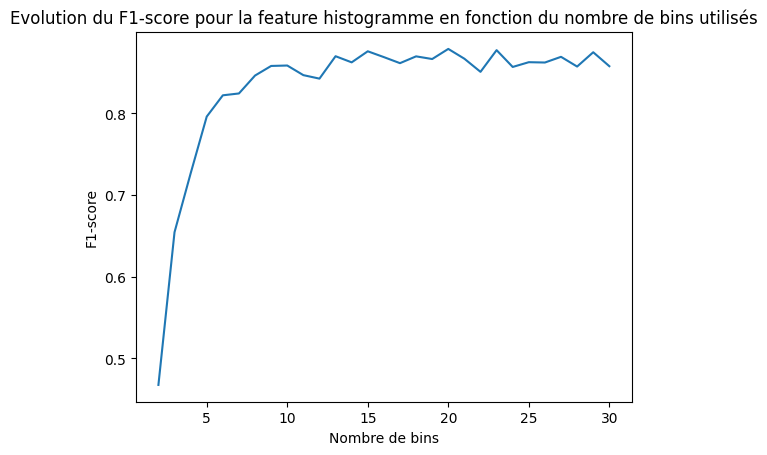

In [100]:
plt.plot(range(2, 31), scores_histo)
plt.xlabel("Nombre de bins")
plt.ylabel("F1-score")
plt.title("Evolution du F1-score pour la feature histogramme en fonction du nombre de bins utilisés")
plt.show()

Meilleurs scores :
* 20 bins : 0.879, avec 8000 features
* 15 bins : 0.876, avec 3375 features
* 13 bins : 0.870, avec 2197 features <br>
Le meilleur compromis score / nombre de features semble être atteint pour 13 bins. <br>
En utilisant uniquement les features générées avec  les histogrammes, le score obtenu en cross validation est meilleur qu'avec l'ensemble des features précédentes concaténées.

In [150]:
histo13 = create_histo_features(13, test_feature=False)
histo13_test = create_histo_features(13, test_feature=True)
histo13.shape, histo13_test.shape

((422, 2197), (207, 2197))

### Local Binary Patterning (LBP)

La librairie Mahotas permet de créer un histogramme de features LBP via la fonction `mahotas.features.lbp`. En revanche, le nombre de features retournées par cette méthode est très (trop) important. Comme conseillé sur le blog suivant (https://cvexplained.wordpress.com/2020/07/22/10-7-local-binary-patterns/), j'ai préféré utiliser l'implémentation de LBP proposée par skimage pour avoir plus de contrôle sur les features générées, et profiter d'une implémentation qui améliore l'invariance par rotation et niveaux de gris. <br>
La génération de features nécessite de fournir un rayon et un nombre de points en entrée. Un nombre de points égal à 8 fois le rayon est recommandé pour rester cohérent avec l'implémentation de LBP, j'ai fait varier le rayon entre 1 et 10 pixels pour trouver une valeur optimale. 

In [103]:
def create_lbp_features(radius, points, test_feature=False):
    """ Extrait les features LBP des images en input
    Args:
        radius (int) : rayon du cercle utilisé pour calculer les features LBP autour d'un pixel
        points (int) : nombre de points à garder dans le cercle défini autour du pixel central
                        Avec points = radius x 8, tous les points sont conservés
        test_feature (Bool): si True, crée des features sur les images de Test, si False créée 
                                des features sur les images de Train
    Output:
        X (numpy array) : features extraites (la dimension de sortie dépend du nombre de bins en argument)
    """
    files = files_test if test_feature else files_train
    X = []
    for f in files:
        im = np.array(Image.open(f).convert('L'))
        lbp = local_binary_pattern(im, points, radius, method="uniform")
        (hist, _) = np.histogram(lbp.ravel(), bins=range(0, points+3), range=(0, points+2))
        X.append(hist)
    return np.stack(X)

In [104]:
scores_lbp = []
for radius in tqdm(range(1, 11)):
    X_tmp = create_lbp_features(radius, 8*radius, test_feature=False)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_tmp)
    reg = range(1, 51)
    score = []
    for c in reg:
        svm = SVC(C=c, kernel=pykernels.Tanimoto())
        score.append(np.mean(cross_val_score(svm, X_scaled, y_train, cv=16, scoring="f1_weighted")))
    print(f"Rayon {radius} : Best score {np.max(score)} - C {np.argmax(score)+1} | Size of X {X_scaled.shape}")
    scores_lbp.append(np.max(score))

  0%|          | 0/10 [00:00<?, ?it/s]

Rayon 1 : Best score 0.47838628509034486 - C 20 | Size of X (422, 10)
Rayon 2 : Best score 0.6575136303234593 - C 9 | Size of X (422, 18)
Rayon 3 : Best score 0.6476158097670164 - C 16 | Size of X (422, 26)
Rayon 4 : Best score 0.6548318727805906 - C 31 | Size of X (422, 34)
Rayon 5 : Best score 0.6758636212829588 - C 18 | Size of X (422, 42)
Rayon 6 : Best score 0.7049250280820794 - C 13 | Size of X (422, 50)
Rayon 7 : Best score 0.7074952810129093 - C 8 | Size of X (422, 58)
Rayon 8 : Best score 0.702283852484173 - C 10 | Size of X (422, 66)
Rayon 9 : Best score 0.6983171288192656 - C 5 | Size of X (422, 74)
Rayon 10 : Best score 0.6696628434876298 - C 4 | Size of X (422, 82)


Le meilleur score est atteint pour un rayon de 7, d'où la création de la feature suivante pour la suite

In [164]:
lbp = create_lbp_features(7, 56, test_feature=False)
lbp_test = create_lbp_features(7, 56, test_feature=True)
lbp.shape, lbp_test.shape

((422, 58), (207, 58))

### Scale-invariant feature transform (SIFT)

Les descripteurs SIFT sont plus souvent utilisés pour l'identification que pour de la classification. Ils semblaient cependant particulièrement dans le contexte de classification, car il s'agit d'une feature invariante d'échelle. L'utilisation des descripteurs pour de la classification n'est pas immédiate, il convient de créer un `bag of visual words` avec les descripteurs SIFT en amont.

<u>Principe </u>: On récupère les descripteurs SIFT de l'ensemble des images (train + test). Chaque keypoint SIFT est décrit par un descripteur de taille 128. On clusterise ensuite ces descripteurs pour trouver les `k` keypoints les plus représentatifs des images. Les descripteurs de chaque image sont ensuite comparés aux `k` descripteurs représentatifs, et un histogramme est constitué pour chaque image (on compte le nombre de fois où un keypoint appartenant au cluster `i` est présent dans l'image). Cela génère donc une feature de taille `k` pour chaque image, qui peut être utilisée dans notre tâche de classification. Cette technique est appelée "Bag of Visual Words" dans les différents articles y faisant référence. <br>
Un critère très important pour la génération des features SIFT est donc la taille `k` du nombre de clusters à générer

<u>Première étape </u>: extraction des keypoints et descripteurs SIFT de l'ensemble des images (Train + Test)

In [106]:
sift = cv2.SIFT_create()
# Certaines images sont de dimension 700x456 : je les resize toutes pour ne pas avoir de problème de dimension
images = [np.array(Image.open(f).convert('L').resize((700,460))) for f in files_train]
images = np.stack(images, axis=0)
# Certaines images sont de dimension 700x456 : je les resize toutes pour ne pas avoir de problème de dimension
images_test = [np.array(Image.open(f).convert('L').resize((700,460))) for f in files_test]
images_test = np.stack(images_test, axis=0)
sift_feat = []
for im in tqdm(images):
    sift_feat.append(sift.detectAndCompute(im, None)[1])
for im in tqdm(images_test):
    sift_feat.append(sift.detectAndCompute(im, None)[1])
sift_feat = np.vstack(sift_feat)

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/207 [00:00<?, ?it/s]

In [107]:
sift_feat.shape

(2225354, 128)

2 225 354 keypoints ont donc été trouvés parmi les 629 images

<u>Deuxième étape </u>: clustering des keypoints SIFT extraits, et décompte du nombre de keypoints représentatif dans chaque image

In [108]:
def create_sift_feature(k, sift_feat, images, images_test):
    """ Fonction utilisée pour créer les features SIFT
    Args:
        k (int) : nombre de cluster / taille des features générées pour chaque image
        sift_feat (numpy array nb_total_keypoints x 128) : contient l'ensemble des keypoints SIFT de l'ensemble des images
        images (numpy array 422x3x460x700) : array contenant l'ensemble des images de Train
        images_test (numpy array 207x3x460x700) : array contenant l'ensemble des images de Test
    Return:
        ∅ : la génération des features étant très longue, elles ont été enregistrées en local pour pouvoir être
        réutilisées plus facilement
    """
    sift = cv2.SIFT_create()
    # 20 initialisations random de KMeans, parmi laquelle la meilleure est gardée
    # Cette étape est assez longue, mais la création du cluster est l'étape la plus cruciale de cette méthode
    kmeans = KMeans(n_clusters=k, init="random", n_init=20)
    kmeans.fit(sift_feat)
    
    X_tmp = []
    for im in images:
        # Extraction des descripteurs de chaque image
        des = sift.detectAndCompute(im, None)[1]
        # Création d'un histogramme vide
        histo = np.zeros(k)
        for d in des:
            # Pour chaque descripteur, association au cluster le plus proche
            idx = kmeans.predict(d.reshape(1, -1))
            histo[idx] += 1
        X_tmp.append(histo)
    X_tmp = np.vstack(X_tmp)
    
    X_tmp_test = []
    for im in images_test:
        des = sift.detectAndCompute(im, None)[1]
        histo = np.zeros(k)
        for d in des:
            idx = kmeans.predict(d.reshape(1, -1))
            histo[idx] += 1
        X_tmp_test.append(histo)
    X_tmp_test = np.vstack(X_tmp_test)
    
    np.save(f"sift_embedding_{k}.npy", X_tmp)
    np.save(f"sift_embedding_test_{k}.npy", X_tmp_test)

L'étape de clustering via K-Means étant assez longue (clustering de plus de 2 000 000 de keypoints), elle a été réalisée en amont de ce rapport, et les embeddings sauvegardés en local au format `npy`. Des embeddings de dimension variant entre 150 et 650 ont été générés.

In [137]:
scores_sift = []
for k in tqdm([150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650]):
    X_tmp = np.load(f"sift_embedding_{k}.npy")
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_tmp)
    reg = range(1, 51)
    score = []
    for c in reg:
        svm = SVC(C=c, kernel=pykernels.Tanimoto())
        score.append(np.mean(cross_val_score(svm, X_scaled, y_train, cv=16, scoring="f1_weighted")))
    print(f"Nombre de clusters {k} : Best score {np.max(score)} - C {np.argmax(score)+1}")
    scores_sift.append(np.max(score))

  0%|          | 0/11 [00:00<?, ?it/s]

Nombre de clusters 150 : Best score 0.7823833880190718 - C 7
Nombre de clusters 200 : Best score 0.7837624873148378 - C 10
Nombre de clusters 250 : Best score 0.7651353073762261 - C 5
Nombre de clusters 300 : Best score 0.7858054758829331 - C 7
Nombre de clusters 350 : Best score 0.7575363985887491 - C 7
Nombre de clusters 400 : Best score 0.7588900178643768 - C 5
Nombre de clusters 450 : Best score 0.779959694863541 - C 3
Nombre de clusters 500 : Best score 0.7525695320032926 - C 6
Nombre de clusters 550 : Best score 0.7726663288739081 - C 10
Nombre de clusters 600 : Best score 0.7497361889455907 - C 8
Nombre de clusters 650 : Best score 0.7559814077976472 - C 4


Le meilleur score est obtenu pour k=300. Ce sont donc les embeddings SIFT de taille 300 qui ont été conservés pour la suite

In [165]:
sift = np.load("sift_embedding_300.npy")
sift_test = np.load("sift_embedding_test_300.npy")
sift.shape, sift_test.shape

((422, 300), (207, 300))

## Optimisation de la combinaison des features

Pour cette ultime étape, les modèles ne sont plus testés sur 16-folds, mais avec `Leave-One-Out`. La méthode est beaucoup plus calculatoire, mais permet d'obtenir des résultats plus robustes, c'est pourquoi je ne l'ai employé qu'à partir de cette étape.

In [129]:
loo = LeaveOneOut()
# Concaténation de toutes les features précédemment extraites
X = np.concatenate([pftas, chan_stats, hu, haralick, histo13, lbp, sift], axis=1)
X_test = np.concatenate([pftas_test, chan_stats_test, hu_test, haralick_test, histo13_test, lbp_test, sift_test],
                        axis=1)

In [130]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)
X_scaled.shape, X_test_scaled.shape

((422, 2764), (207, 2764))

In [122]:
reg = range(1, 31)
score = []
for c in tqdm(reg):
    svm = SVC(C=c, kernel=pykernels.Tanimoto())
    f1 = []
    for i, (train_index, test_index) in enumerate(loo.split(X_scaled)):
        svm.fit(X_scaled[train_index], y_train[train_index])
        y_pred = svm.predict(X_scaled[test_index])
        f1.append(f1_score(y_train[test_index], y_pred, average="weighted"))
    score.append(np.mean(f1))
print(f"Best score {np.max(score)} - C {np.argmax(score)+1}")

  0%|          | 0/30 [00:00<?, ?it/s]

Best score 0.9170616113744076 - C 4


In [163]:
svm = SVC(C=4, kernel=pykernels.Tanimoto())
svm.fit(X_scaled, y_train)
y_pred = svm.predict(X_test_scaled)
df_pred = pd.concat([pd.Series(np.arange(1,208)), pd.Series(y_pred)], axis=1)
df_pred.to_csv('pred_full_features.csv', index=False, header=False)

**Le score obtenu avec cette soumission est de  0.794713651235**.<br>
On remarque que le nombre de features utilisé est relativement important (2764). Utiliser PCA sur cette représentation des données pour réduire la dimension serait drastique (l'implémentation de scitkit-learn de PCA autoriserait l'utilisation maximale de 422 features...). Un test d'ablation de features a donc été favorisé pour voir s'il était possible d'améliorer le score en enlevant une ou plusieurs features.

<u>Test d'ablations de features</u>

In [138]:
features = [pftas, chan_stats, hu, haralick, histo13, lbp, sift]
feature_names = ["PFTAS", "Channel statistics", "Hu Moments", "Haralick", "Histogramme", "LBP", "SIFT"]
for feat in tqdm(range(len(features))):
    list_feat = copy.deepcopy(features)
    # Supprime la feature feat de la liste des features avant concaténation
    del list_feat[feat]
    X = np.concatenate(list_feat, axis=1)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    reg = range(1, 31)
    score = []
    for c in tqdm(reg):
        svm = SVC(C=c, kernel=pykernels.Tanimoto())
        f1 = []
        for i, (train_index, test_index) in enumerate(loo.split(X_scaled)):
            svm.fit(X_scaled[train_index], y_train[train_index])
            y_pred = svm.predict(X_scaled[test_index])
            f1.append(f1_score(y_train[test_index], y_pred, average="weighted"))
        score.append(np.mean(f1))
    print(f"Feature removed {feature_names[feat]} : Best score {np.max(score)} - C {np.argmax(score)+1}")

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Feature removed PFTAS : Best score 0.919431279620853 - C 3


  0%|          | 0/30 [00:00<?, ?it/s]

Feature removed Channel statistics : Best score 0.9170616113744076 - C 6


  0%|          | 0/30 [00:00<?, ?it/s]

Feature removed Hu Moments : Best score 0.9146919431279621 - C 4


  0%|          | 0/30 [00:00<?, ?it/s]

Feature removed Haralick : Best score 0.9146919431279621 - C 4


  0%|          | 0/30 [00:00<?, ?it/s]

Feature removed Histogramme : Best score 0.933649289099526 - C 3


  0%|          | 0/30 [00:00<?, ?it/s]

Feature removed LBP : Best score 0.9218009478672986 - C 5


  0%|          | 0/30 [00:00<?, ?it/s]

Feature removed SIFT : Best score 0.919431279620853 - C 7


De manière surprenante, il semblerait qu'en enlevant les features générées via histogramme de couleur, le score global soit amélioré ! J'ai donc recrée une soumission après avoir enlevée les features d'histogramme.

In [166]:
X = np.concatenate([pftas, chan_stats, hu, haralick, lbp, sift], axis=1)
X_test = np.concatenate([pftas_test, chan_stats_test, hu_test, haralick_test, lbp_test, sift_test],
                        axis=1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)
X_scaled.shape, X_test_scaled.shape

((422, 567), (207, 567))

In [168]:
svm = SVC(C=3, kernel=pykernels.Tanimoto())
svm.fit(X_scaled, y_train)
y_pred = svm.predict(X_test_scaled)
df_pred = pd.concat([pd.Series(np.arange(1,208)), pd.Series(y_pred)], axis=1)
df_pred.to_csv('pred_ablation.csv', index=False, header=False)

**Le score obtenu avec cette soumission est de 0.770335965359**, soit 2 points de moins que précédemment. <br>
La suppression des features d'histogramme semble avoir abouti à un overfitting du modèle. Retirer entièrement ces features ne semble donc pas pertinent. En revanche, **les features d'histogramme comptent pour 2197 features / 2764**. Peut-être est-il possible de réduire le nombre de bins utilisé ? Le nombre de bins avait été estimé en utilisant uniquement les features d'histogramme. Après combinaison avec d'autres features, il est probablement possible d'utiliser moins de bins pour réduire la dimension et d'obtenir un meilleur score final. <br><br>

<u>Optimisation du nombre de bins d'histogramme conjointement aux autres features</u> (range de recherche entre 10 et 15 bins)

In [153]:
for bins in tqdm([10, 11, 12, 13, 14, 15]):
    histo = create_histo_features(bins, test_feature=False)
    histo_test = create_histo_features(bins, test_feature=True)
    X = np.concatenate([pftas, chan_stats, hu, haralick, histo, lbp, sift], axis=1)
    X_test = np.concatenate([pftas_test, chan_stats_test, hu_test, haralick_test, histo_test, lbp_test, sift_test],
                        axis=1)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_test_scaled = scaler.transform(X_test)
    print(f"Dimensions X {X_scaled.shape}")
    reg = range(1, 11)
    score = []
    for c in reg:
        svm = SVC(C=c, kernel=pykernels.Tanimoto())
        f1 = []
        for i, (train_index, test_index) in enumerate(loo.split(X_scaled)):
            svm.fit(X_scaled[train_index], y_train[train_index])
            y_pred = svm.predict(X_scaled[test_index])
            f1.append(f1_score(y_train[test_index], y_pred, average="weighted"))
        score.append(np.mean(f1))
    print(f"Bins {bins} : Best score {np.max(score)} - C {np.argmax(score)+1}")

  0%|          | 0/6 [00:00<?, ?it/s]

Dimensions X (422, 1567)
Bins 10 : Best score 0.9218009478672986 - C 4
Dimensions X (422, 1898)
Bins 11 : Best score 0.9241706161137441 - C 6
Dimensions X (422, 2295)
Bins 12 : Best score 0.9170616113744076 - C 4
Dimensions X (422, 2764)
Bins 13 : Best score 0.9170616113744076 - C 4
Dimensions X (422, 3311)
Bins 14 : Best score 0.9218009478672986 - C 4
Dimensions X (422, 3942)
Bins 15 : Best score 0.9218009478672986 - C 4


In [154]:
histo11 = create_histo_features(11, test_feature=False)
histo11_test = create_histo_features(11, test_feature=True)

Il semblerait qu'utiliser seulement 11 bins permette d'augmenter le score global de classification. <br>
Peut-être est-il également possible d'optimiser le nombre de features LBP créées?

In [161]:
for radius in tqdm(range(2,12)):
    lbp = create_lbp_features(radius, 8*radius, test_feature=False)
    lbp_test = create_lbp_features(radius, 8*radius, test_feature=True)
    X = np.concatenate([pftas, chan_stats, hu, haralick, histo11, lbp, sift], axis=1)
    X_test = np.concatenate([pftas_test, chan_stats_test, hu_test, haralick_test, histo11_test, lbp_test, sift_test],
                        axis=1)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_test_scaled = scaler.transform(X_test)
    print(f"Dimensions X {X_scaled.shape}")
    reg = range(1, 11)
    score = []
    for c in reg:
        svm = SVC(C=c, kernel=pykernels.Tanimoto())
        f1 = []
        for i, (train_index, test_index) in enumerate(loo.split(X_scaled)):
            svm.fit(X_scaled[train_index], y_train[train_index])
            y_pred = svm.predict(X_scaled[test_index])
            f1.append(f1_score(y_train[test_index], y_pred, average="weighted"))
        score.append(np.mean(f1))
    print(f"Radius={radius} : Best score {np.max(score)} - C {np.argmax(score)+1}")

  0%|          | 0/10 [00:00<?, ?it/s]

Dimensions X (422, 1858)
Radius=2 : Best score 0.9146919431279621 - C 4
Dimensions X (422, 1866)
Radius=3 : Best score 0.9146919431279621 - C 4
Dimensions X (422, 1874)
Radius=4 : Best score 0.919431279620853 - C 6
Dimensions X (422, 1882)
Radius=5 : Best score 0.9170616113744076 - C 3
Dimensions X (422, 1890)
Radius=6 : Best score 0.9218009478672986 - C 3
Dimensions X (422, 1898)
Radius=7 : Best score 0.9241706161137441 - C 6
Dimensions X (422, 1906)
Radius=8 : Best score 0.9265402843601895 - C 7
Dimensions X (422, 1914)
Radius=9 : Best score 0.9265402843601895 - C 6
Dimensions X (422, 1922)
Radius=10 : Best score 0.9265402843601895 - C 6
Dimensions X (422, 1930)
Radius=11 : Best score 0.9241706161137441 - C 5


Utiliser un rayon de 9 pixels pour la feature de LBP semble améliorer légèrement le score.

In [169]:
lbp = create_lbp_features(9, 8*9, test_feature=False)
lbp_test = create_lbp_features(9, 8*9, test_feature=True)

In [170]:
X = np.concatenate([pftas, chan_stats, hu, haralick, histo11, lbp, sift], axis=1)
X_test = np.concatenate([pftas_test, chan_stats_test, hu_test, haralick_test, histo11_test, lbp_test, sift_test],
                        axis=1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)
X_scaled.shape, X_test_scaled.shape

((422, 1914), (207, 1914))

In [172]:
svm = SVC(C=6, kernel=pykernels.Tanimoto())
svm.fit(X_scaled, y_train)
y_pred = svm.predict(X_test_scaled)
df_pred = pd.concat([pd.Series(np.arange(1,208)), pd.Series(y_pred)], axis=1)
df_pred.to_csv('pred_ultime.csv', index=False, header=False)

**Le score obtenu avec cette dernière soumission est de 0.802604153216**. <br>
Il semble difficile d'optimiser davantage ce score avec cette méthode sans overfitter.

## Conclusion

Pour obtenir un F1-score optimal de **0.802604153216**, les paramètres suivants ont donc été utilisés :
* Classifieur **SVM avec kernel Tanimoto**, paramètre de régularisation **C=6**
* 7 feature extractors
  1) Parameter-Free Threshold Adjacency Statistics
  2) Statistiques des canaux de couleur (moyenne, écart-type, asymétrie, kurtosis)
  3) Hu Moments
  4) Features de texture Haralick (distance=2, moyenne Point-to-Point et 14 features calculées)
  5) Histogramme de couleurs avec 11 bins
  6) Local Binary Patterning, avec un rayon de 9 pixels et 72 points
  7) Descripteurs SIFT, clusterisés avec 300 centroides

<u>Autres méthodes testées amenant à un 0.76 < F1-Score < 0.79  </u>:
* PCA (~35 composantes) avec features histogramme + Haralick + PFTAS
* 7 features avec kernel de Cauchy et optimisation du paramètre `s` (variance $\sigma$)
* Classifieur Deep Learning avec 4 couche de convolutions et quelques couches linéaires, appliqué sur des patchs d'images (patchs de taille 115 x 100 px, soit 28 patchs par image de taille 460 x 700 px), suivi d'un hard vote sur les 28 patchs d'image pour identifier la classe de l'image complète (similaire à un vote dans une méthode d'ensemble)

<u>Pistes potentielles d'améliorations </u>:
* Utilisation de classifieurs plus complexes (XGBoost, méthodes d'ensemble incluant des SVM avec des kernels différents), avec GridSearchCV pour rechercher les paramètres optimaux -> de très longs temps de calcul en perspective
* Optimisation d'un classifieur avec CNN plus profond que celui testé, appliqué à des patchs d'images -> nécessite l'accès à des GPUs pour obtenir des résultats dans un temps raisonnable

# Annexe - Code complet pour générer les meilleurs prédictions

Il est déconseillé de lancer le code tel quel, la génération des features - en particulier SIFT- étant assez longue.

In [ ]:
import numpy as np
import os
from tqdm.notebook import tqdm
from PIL import Image
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy.stats import skew, kurtosis
import pandas as pd
import cv2
import mahotas
from skimage.feature import local_binary_pattern
# A installer depuis https://github.com/gmum/pykernels.git
import pykernels


# -------- Récupération des images et labels d'entraînement --------
class_mapping = {"F":1, "DC":2, "PC":3, "PT":4, "MC":5, "LC":6, "A":7, "TA":8}
# Liste contenant le nom des fichiers de Train
files_train = [f"data-challenge/Train/{f}" for f in os.listdir(path="data-challenge/Train/")]
# Liste contenant le nom des fichiers de Test
files_test = [f"data-challenge/Test/SOB_{i}.png" for i in range(1, 208)]
y_train = np.array([int(class_mapping[f.split("_")[2].split("-")[0]]) for f in files_train])


# -------- 1) Extraction features PFTAS --------
pftas = np.array([mahotas.features.pftas(np.array(Image.open(f))) for f in files_train])
pftas_test = np.array([mahotas.features.pftas(np.array(Image.open(f))) for f in files_test])


# -------- 2) Extraction features statistiques de couleurs --------
chan_stats = np.array([np.concatenate([np.mean(Image.open(f), axis=(0,1)),
                                       np.std(Image.open(f), axis=(0,1)),
                                       skew(Image.open(f), axis=(0,1)),
                                       kurtosis(Image.open(f), axis=(0,1))]) for f in files_train])
chan_stats_test = np.array([np.concatenate([np.mean(Image.open(f), axis=(0,1)),
                                       np.std(Image.open(f), axis=(0,1)),
                                       skew(Image.open(f), axis=(0,1)),
                                       kurtosis(Image.open(f), axis=(0,1))]) for f in files_test])


# -------- 3) Extraction features Hu moments --------
moments = [cv2.moments(np.array(Image.open(f).convert('L'))) for f in files_train]
moments_test = [cv2.moments(np.array(Image.open(f).convert('L'))) for f in files_test]
hu = np.array([cv2.HuMoments(m).T for m in moments])[:,0,:]
hu_test = np.array([cv2.HuMoments(m).T for m in moments_test])[:,0,:]


# -------- 4) Extraction features Haralick --------
haralick = np.array([mahotas.features.haralick(np.array(Image.open(f)), return_mean_ptp=True,
                                         compute_14th_feature=True, distance=2) for f in files_train])
haralick_test = np.array([mahotas.features.haralick(np.array(Image.open(f)), return_mean_ptp=True,
                                         compute_14th_feature=True, distance=2) for f in files_test])


# -------- 5) Extraction features Histogrammes --------
def create_histo_features(bins, test_feature=False):
    """ Créée des histogrammes de couleurs pour chaque canal HSV des images en input
    Args:
        bins (int) : nombre de bins (classes) à créer pour chaque canal de l'image HSV
        test_feature (Bool): si True, crée des features sur les images de Test, si False créée 
                                des features sur les images de Train
    Output:
        X (numpy array) : features extraites (la dimension de sortie dépend du nombre de bins en argument)
    """
    files = files_test if test_feature else files_train
    X = []
    for f in files:
        hsv = cv2.cvtColor(cv2.imread(f), cv2.COLOR_BGR2HSV)
        hist  = cv2.calcHist([hsv], [0, 1, 2], None, [bins, bins, bins], [0, 256, 0, 256, 0, 256])
        cv2.normalize(hist, hist)
        X.append(hist.flatten())
    X = np.array(X)
    return X

histo11 = create_histo_features(11, test_feature=False)
histo11_test = create_histo_features(11, test_feature=True)


# -------- 6) Extraction features LBP --------
# Inspiration : https://cvexplained.wordpress.com/2020/07/22/10-7-local-binary-patterns/
def create_lbp_features(radius, points, test_feature=False):
    """ Extrait les features LBP des images en input
    Args:
        radius (int) : rayon du cercle utilisé pour calculer les features LBP autour d'un pixel
        points (int) : nombre de points à garder dans le cercle défini autour du pixel central
                        Avec points = radius x 8, tous les points sont conservés
        test_feature (Bool): si True, crée des features sur les images de Test, si False créée 
                                des features sur les images de Train
    Output:
        X (numpy array) : features extraites (la dimension de sortie dépend du nombre de bins en argument)
    """
    files = files_test if test_feature else files_train
    X = []
    for f in files:
        im = np.array(Image.open(f).convert('L'))
        lbp = local_binary_pattern(im, points, radius, method="uniform")
        (hist, _) = np.histogram(lbp.ravel(), bins=range(0, points+3), range=(0, points+2))
        X.append(hist)
    return np.stack(X)

lbp = create_lbp_features(9, 8*9, test_feature=False)
lbp_test = create_lbp_features(9, 8*9, test_feature=True)


# -------- 7) Extraction features SIFT --------
# Inspiration : https://www.kaggle.com/code/pierre54/bag-of-words-model-with-sift-descriptors/notebook
def create_sift_feature(k, sift_feat, images, images_test):
    """ Fonction utilisée pour créer les features SIFT
    Args:
        k (int) : nombre de cluster / taille des features générées pour chaque image
        sift_feat (numpy array nb_total_keypoints x 128) : contient l'ensemble des keypoints SIFT de l'ensemble des images
        images (numpy array 422x3x460x700) : array contenant l'ensemble des images de Train
        images_test (numpy array 207x3x460x700) : array contenant l'ensemble des images de Test
    Return:
        ∅ : la génération des features étant très longue, elles ont été enregistrées en local pour pouvoir être
        réutilisées plus facilement
    """
    sift = cv2.SIFT_create()
    # 20 initialisations random de KMeans, parmi laquelle la meilleure est gardée
    # Cette étape est assez longue, mais la création du cluster est l'étape la plus cruciale de cette méthode
    kmeans = KMeans(n_clusters=k, init="random", n_init=20)
    kmeans.fit(sift_feat)
    
    X_tmp = []
    for im in images:
        # Extraction des descripteurs de chaque image
        des = sift.detectAndCompute(im, None)[1]
        # Création d'un histogramme vide
        histo = np.zeros(k)
        for d in des:
            # Pour chaque descripteur, association au cluster le plus proche
            idx = kmeans.predict(d.reshape(1, -1))
            histo[idx] += 1
        X_tmp.append(histo)
    X_tmp = np.vstack(X_tmp)
    
    X_tmp_test = []
    for im in images_test:
        des = sift.detectAndCompute(im, None)[1]
        histo = np.zeros(k)
        for d in des:
            idx = kmeans.predict(d.reshape(1, -1))
            histo[idx] += 1
        X_tmp_test.append(histo)
    X_tmp_test = np.vstack(X_tmp_test)
    
    np.save(f"sift_embedding_{k}.npy", X_tmp)
    np.save(f"sift_embedding_test_{k}.npy", X_tmp_test)

sift = cv2.SIFT_create()
# Certaines images sont de dimension 700x456 : je les resize toutes pour ne pas avoir de problème de dimension
images = [np.array(Image.open(f).convert('L').resize((700,460))) for f in files_train]
images = np.stack(images, axis=0)
# Certaines images sont de dimension 700x456 : je les resize toutes pour ne pas avoir de problème de dimension
images_test = [np.array(Image.open(f).convert('L').resize((700,460))) for f in files_test]
images_test = np.stack(images_test, axis=0)

# Extraction des descripteurs SIFT de toutes les images
sift_feat = []
for im in tqdm(images):
    sift_feat.append(sift.detectAndCompute(im, None)[1])
for im in tqdm(images_test):
    sift_feat.append(sift.detectAndCompute(im, None)[1])
sift_feat = np.vstack(sift_feat)

# Création des features SIFT
# Attention, la génération prend beaucoup de temps (cf. n_init=20 pour le K-Means)
create_sift_feature(300, sift_feat, images, images_test)
sift = np.load("sift_embedding_300.npy")
sift_test = np.load("sift_embedding_test_300.npy")


# -------- Concaténation des features et fitting du modèle --------
X = np.concatenate([pftas, chan_stats, hu, haralick, histo11, lbp, sift], axis=1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
svm = SVC(C=6, kernel=pykernels.Tanimoto())
svm.fit(X_scaled, y_train)


# -------- Génération des prédictions --------
X_test = np.concatenate([pftas_test, chan_stats_test, hu_test, haralick_test, histo11_test, lbp_test, sift_test],
                        axis=1)
X_test_scaled = scaler.transform(X_test)
y_pred = svm.predict(X_test_scaled)
df_pred = pd.concat([pd.Series(np.arange(1,208)), pd.Series(y_pred)], axis=1)
df_pred.to_csv('predictions.csv', index=False, header=False)